In [43]:

import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
import numpy as np

from matplotlib import pyplot as plt
from crawlab_toolbox import plotting as genplt
from sklearn.pipeline import Pipeline

import tensorflow.keras as keras

from scipy.stats import probplot
from scipy.stats import normaltest

# mse = keras.metrics.mean_squared_error(all_outputs,input_data)

In [44]:
import matplotlib as mpl
print(mpl.__version__)

3.2.1


In [45]:
inferenceLocations = ['No-Vib','Time-Only']
vibSamples = ['4096','8192','16384','32768','65536']
vibSampleLabels = [r'$2^{12}$',r'$2^{13}$',r'$2^{14}$',r'$2^{15}$',r'$2^{16}$']

basePath = 'Edge-Device-Latency/Beaglebone_'
deviceId = 'Amazon-EC2'
numSamples = 750
numColumns = 3

extractLatency = np.zeros((numSamples,len(inferenceLocations),len(vibSamples)))
inferenceLatency = np.zeros((numSamples,len(inferenceLocations),len(vibSamples)))
columns = None

In [46]:
for i in range(len(vibSamples)):
    for j in range(len(inferenceLocations)):
        thisDF = pd.read_csv(basePath + inferenceLocations[j] +'_' + vibSamples[i] + '.csv')

        print(thisDF.values.shape)


        extractLatency[:,j,i] = thisDF.values[-numSamples:,1]
#         inferenceLatency[:,j,i] = thisDF.values[-numSamples:,2]



(1000, 3)
(853, 2)
(1000, 3)
(1000, 2)
(1000, 3)
(1000, 2)
(1000, 3)
(1000, 2)
(1000, 3)
(1000, 2)


mean latency, max latency, Max Score Difference, MSE

In [47]:
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628']

def box_plot(data,labels,
             xlabel='',ylabel='Latency (ms)',log_y=False,
             folder='figures',filename='boxplot',savefig=False,
             transparent=True,color_order=np.arange(len(colors)),template='publication',
             xtickpad=5,showfliers=False,plot_type='box'):
    thisColors = [colors[i] for i in color_order]
    if template.lower() == 'publication':
        fig = plt.figure(figsize=(6,4))
    elif template.lower() == 'wide':
        fig = plt.figure(figsize=(12,4))
    elif template.lower() == 'presentation':
        fig = plt.figure(figsize=(9,6))
    else:
        fig = plt.figure()

    if plot_type == 'box':

        bp = plt.boxplot(data,
                        showfliers=showfliers,
                        patch_artist=True,
                        meanline=False,
                        notch=False,
                        medianprops={'color':'black',
                                     'linewidth':2},
                        whiskerprops={'linewidth':2},
                        capprops={'linewidth':2})
        ax = plt.gca()

        for patch, color in zip(bp['boxes'], thisColors):
            # change outline color
            patch.set(color=color, linewidth=2)
            patch.set_facecolor(color)
    else:
        violin_parts = plt.violinplot(data,
                  showmeans=False,
                  showmedians=False,
                  showextrema=False)
        ax = plt.gca()
        
        for pc in violin_parts['bodies']:
            pc.set_facecolor('red')
            pc.set_edgecolor('black')

    if log_y == True:
        ax.set_yscale('log')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    ax.set_xticklabels([r'\textbf{' + label + '}' for label in labels])
    ax.tick_params(axis='x', which='major', pad=xtickpad)
    plt.xlabel(r'\textbf{' + xlabel + '}')
    plt.ylabel(r'\textbf{' + ylabel + '}')
    
    if not os.path.exists(folder):
        os.makedirs(folder)
        
    plt.tight_layout(pad=1.5)
    
    if savefig:
        plt.savefig(folder + '/' + filename + '.png',transparent=transparent)

    plt.show()
    
    
def box_plot_compare(data,labels,dataLabels,
             xlabel='',ylabel='Latency (ms)',log_y=False,
             folder='figures',filename='boxplot',savefig=False,
             transparent=True,color_order=np.arange(len(colors)),template='publication',
             xtickpad=5,showfliers=False,legend_loc='best',max_cutoff=0,min_cutoff=0,plot_type='violin'):
    thisColors = [colors[i] for i in color_order]
    if template.lower() == 'publication':
        fig = plt.figure(figsize=(6,4))
    elif template.lower() == 'wide':
        fig = plt.figure(figsize=(12,4))
    elif template.lower() == 'presentation':
        fig = plt.figure(figsize=(9,6))
    else:
        fig = plt.figure()
        
    position = [i+1 for i in range(data.shape[1])]
    tickPositions = []
    phantomLines = []
        
    for i in range(data.shape[-1]):
        
        max_index = data.shape[0] - max_cutoff
        min_index = min_cutoff
        
        thisData = np.sort(data[...,i],axis=0)[min_index:max_index,:]
        
        if plot_type=='violin':

            violin_parts = plt.violinplot(thisData,
                      positions = position,
                      showmeans=False,
                      showmedians=False,
                      showextrema=False)

            for counter, pc in enumerate(violin_parts['bodies']):
                pc.set_facecolor(colors[counter])
                pc.set_edgecolor('black')
                pc.set_alpha(1)

                if i == 0:
                    line, = plt.plot([1,1],color=colors[counter])
                    phantomLines.append(line)
                    
        else:
           
            print(np.mean(thisData,axis=0))
            bp = plt.boxplot(thisData,
                            positions=position,
                            showfliers=showfliers,
                            patch_artist=True,
                            meanline=False,
                            notch=False,
                            medianprops={'color':'black',
                                         'linewidth':2},
                            whiskerprops={'linewidth':2},
                            capprops={'linewidth':2},
                            widths=0.75)
            
            for counter,patch in enumerate(bp['boxes']):
                print(counter)
                # change outline color
                patch.set(color=colors[counter], linewidth=2)
                patch.set_facecolor(colors[counter])
                
                if i == 0:
                    line, = plt.plot([1,1],color=colors[counter])
                    phantomLines.append(line)
            
        tickPositions.append(np.mean(position))    
        position = [position[i] + data.shape[1] + 1 for i in range(len(position))]
            
    ax = plt.gca()

    if log_y == True:
        ax.set_yscale('log')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    ax.set_xticklabels([r'\textbf{' + label + '}' for label in labels])
    print(tickPositions)
    ax.set_xticks(tickPositions)
    ax.tick_params(axis='x', which='major', pad=xtickpad)
    ax.legend(tuple(phantomLines),tuple(dataLabels),loc=legend_loc,framealpha=float(not transparent)).get_frame().set_edgecolor('k')
    
    [phantomLines[i].set_visible(False) for i in range(len(phantomLines))]
    
    plt.xlabel(r'\textbf{' + xlabel + '}')
    plt.ylabel(r'\textbf{' + ylabel + '}')
    
    if not os.path.exists(folder):
        os.makedirs(folder)
        
    plt.tight_layout(pad=1.5)
    
    if savefig:
        plt.savefig(folder + '/' + filename + '.png',transparent=transparent)

    plt.show()
    

[0.17906667 0.07366667]
0
1
[0.22922133 0.07364933]
0
1
[0.33221867 0.08779467]
0
1
[0.537684   0.12630133]
0
1
[0.93640667 0.19006   ]
0
1
[1.5, 4.5, 7.5, 10.5, 13.5]


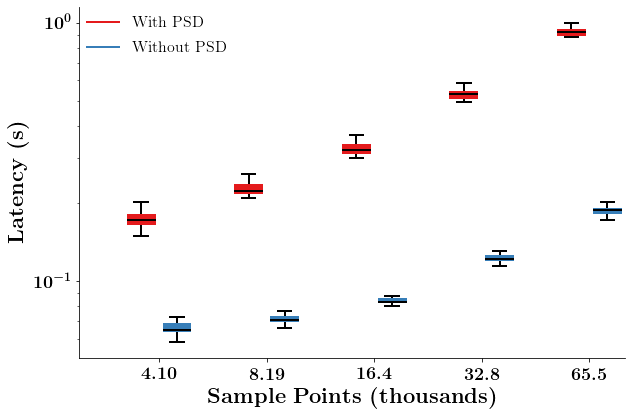

In [48]:
vibSampleLabels = [r'\textbf{4.10}',r'\textbf{8.19}',r'\textbf{16.4}',r'\textbf{32.8}',r'\textbf{65.5}']

box_plot_compare((extractLatency)/1000,vibSampleLabels,['With PSD','Without PSD'],savefig=True,filename='Edge_ExtractLatency_',
         template='Presentation',xlabel='Sample Points (thousands)',color_order=np.zeros(6).astype(int),ylabel='Latency (s)',
         showfliers=False,legend_loc='upper left',max_cutoff=0,plot_type='box',
         log_y=True)

# box_plot_compare((inferenceLatency)/1000,vibSampleLabels,savefig=True,filename='Edge_InferenceLatency_' + modelId,
#          template='wide',xlabel='Sample Points',color_order=np.zeros(6).astype(int),ylabel='Latency (s)',
#          showfliers=True,legend_loc='upper left',max_cutoff=0,
#          log_y=False)

In [33]:
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [34]:
mean_confidence_interval(extractLatency[:,0,0],confidence=99)

(179.06666666666666, nan, nan)

In [32]:
print(np.percentile(extractLatency,50,axis=0))
print(np.percentile(extractLatency,95,axis=0))
print(np.percentile(extractLatency,99,axis=0))

[[172. 224. 322. 531. 922.]
 [ 65.  71.  83. 122. 188.]]
[[ 204.    250.1   364.55  563.55 1074.7 ]
 [ 109.3    85.     98.    142.55  202.  ]]
[[ 462.    281.53  620.53  838.   1273.53]
 [ 164.53  103.04  176.18  170.51  214.51]]
